In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import os
from PIL import Image
from tqdm.auto import tqdm
import torchvision
import pandas as pd
from torchvision import datasets, transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# VAE hyperparameters
vae_latent_dim = 64
vae_hidden_dim = 400
vae_epochs = 25
vae_batch_size = 128
vae_lr = 1e-3

# Diffusion hyperparameters
diffusion_T = 250         # number of diffusion steps
diffusion_epochs = 25
diffusion_batch_size = 128
diffusion_lr = 2e-4


Using device: cuda


In [ ]:
import gdown
import zipfile

os.makedirs("celeba_gan", exist_ok=True)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
attr_url = "https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with zipfile.ZipFile(output, "r") as zipobj:
        zipobj.extractall("celeba_gan")

#gdown.download(attr_url, "list_attr_celeba.txt", quiet=False)
# upload list_attr_celeba.txt to the celeba_gan folder manually

In [ ]:
def map_celeba_to_label(attr):
    blond     = attr['Blond_Hair'] == 1
    brown     = attr['Brown_Hair'] == 1
    glasses   = attr['Eyeglasses'] == 1
    hat       = attr['Wearing_Hat'] == 1

    if blond:
        return 0
    if brown:
        return 1
    if glasses:
        return 2
    if hat:
        return 3
    return 4  


In [ ]:
attr_file = "list_attr_celeba.txt"
df = pd.read_csv(attr_file, sep=r"\s+", skiprows=1)
df.index = df.index.astype(str)

In [ ]:
class CelebAWithAttrs(Dataset):
    def __init__(self, root, attr_df, transform=None):
        self.root = root
        self.attr_df = attr_df
        self.transform = transform

        self.files = sorted(os.listdir(root)) 

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        attrs = self.attr_df.loc[img_name]
        attrs = attrs.to_dict()

        cond = map_celeba_to_label(attrs)

        return img, cond


In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
])


from torchvision.datasets import ImageFolder

dataset = CelebAWithAttrs(
    root="celeba_gan/img_align_celeba",
    attr_df=df,
    transform=transform
)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader_vae = DataLoader(train_dataset, batch_size=vae_batch_size, shuffle=True)
test_loader_vae  = DataLoader(test_dataset, batch_size=vae_batch_size, shuffle=False)


print("Train size:", len(train_dataset), "Test size:", len(test_dataset))

Train size: 182339 Test size: 20260


## 1. VAE: CELEBA → Latent → CELEBA



In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_channels=16):
        """
        Args:
            latent_channels: Number of channels in the latent space.
        """
        super().__init__()
        self.latent_channels = latent_channels

        # -------- Encoder: 3x64x64 → latent_channelsx8x8 --------
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.Conv2d(256, 512, 3, 1, 1), 
            nn.SiLU(inplace=True),
        )

        self.conv_mu     = nn.Conv2d(512, latent_channels, 3, padding=1)
        self.conv_logvar = nn.Conv2d(512, latent_channels, 3, padding=1)

        # -------- Decoder: latent_channelsx8x8 → 3x64x64 --------
        self.dec = nn.Sequential(
            nn.Conv2d(latent_channels, 512, 3, padding=1),
            nn.SiLU(inplace=True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        h = self.enc(x)
        mu = self.conv_mu(h)
        logvar = self.conv_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    @torch.no_grad()
    def encode_to_2d_latent(self, x):
        mu, _ = self.encode(x)
        return mu

    def decode_from_2d_latent(self, z):
        return self.decode(z)

In [ ]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl


In [ ]:
vae = VAE().to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=vae_lr)

print(vae)


VAE(
  (enc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SiLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): SiLU(inplace=True)
  )
  (conv_mu): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_logvar): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec): Sequential(
    (0): Conv2d(16, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU(inplace=True)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU(inplace=True)
    (6): ConvTranspose2d(128, 64, ker

## Reconstruction

In [ ]:
ckpt = torch.load("checkpoint_vae (1).pth", map_location=device)

vae = VAE(latent_channels=16).to(device)
vae.load_state_dict(ckpt["vae_state"])

vae.eval()  
for p in vae.parameters():
    p.requires_grad = False

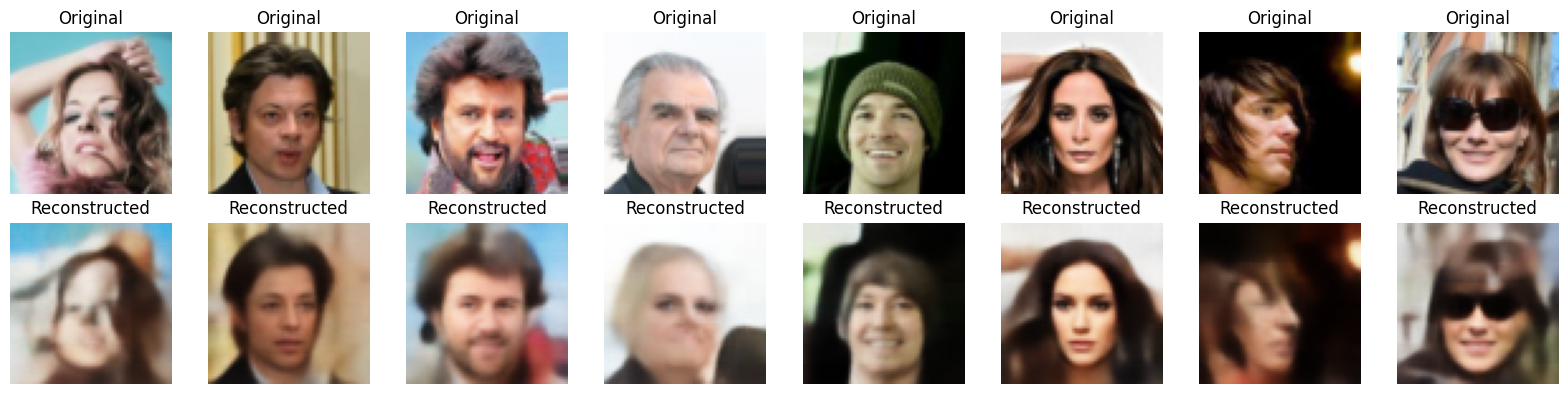

In [ ]:
vae.eval()
x_batch, _ = next(iter(test_loader_vae))  
x_batch = x_batch.to(device)

with torch.no_grad():
    x_hat, mu, logvar = vae(x_batch)

x_batch = x_batch.cpu()
x_hat = x_hat.cpu()

x_batch = (x_batch + 1) / 2
x_hat = (x_hat + 1) / 2


n = 8
plt.figure(figsize=(2 * n, 4))

for i in range(n):

    plt.subplot(2, n, i + 1)
    plt.imshow(x_batch[i].permute(1, 2, 0)) 
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2, n, n + i + 1)
    plt.imshow(x_hat[i].permute(1, 2, 0))
    plt.axis("off")
    plt.title("Reconstructed")

plt.tight_layout()
plt.show()


## Generation

In [ ]:
vae.eval()

@torch.no_grad()
def encode_to_latent(x):
    x = x.to(device)
    mu, logvar = vae.encode(x)
    return mu


In [ ]:
T = diffusion_T

beta_start = 1e-4
beta_end   = 0.02

betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]], dim=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

def q_sample(z0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(z0)
    sqrt_ac = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_om = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_ac * z0 + sqrt_om * noise

def sample_timesteps(batch_size):
    return torch.randint(low=0, high=T, size=(batch_size,), device=device)

def sinusoidal_time_embedding(timesteps, dim):
    device_ = timesteps.device
    half_dim = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device_) * -emb)
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb


In [ ]:
time_embed_dim = 128
label_embed_dim = 128
base_channels  = 192
num_classes    = 10
guidance_scale = 3.0
drop_cond_prob = 0.1

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, cond_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.cond_proj = nn.Linear(cond_dim, 2 * out_ch)

        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, cond):
        gamma, beta = self.cond_proj(cond).chunk(2, dim=1)
        gamma = gamma[..., None, None]
        beta  = beta[..., None, None]

        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        h = self.norm2(h)
        h = h * (1 + gamma) + beta
        h = F.silu(h)
        h = self.conv2(h)

        return h + self.skip(x)


class LatentUNet(nn.Module):
    def __init__(self, in_ch=16, base_ch=192, time_dim=128, label_dim=128):
        super().__init__()

        cond_dim = time_dim + label_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        self.label_mlp = nn.Sequential(
            nn.Linear(label_dim, label_dim),
            nn.SiLU(),
            nn.Linear(label_dim, label_dim),
        )

        self.conv_in = nn.Conv2d(in_ch, base_ch, 3, padding=1)

        self.down1 = ResidualBlock(base_ch, base_ch, cond_dim)
        self.down2 = ResidualBlock(base_ch, base_ch * 2, cond_dim)
        self.pool1 = nn.AvgPool2d(2) 
        self.down3 = ResidualBlock(base_ch * 2, base_ch * 4, cond_dim)
        self.pool2 = nn.AvgPool2d(2)  

        self.mid = ResidualBlock(base_ch * 4, base_ch * 4, cond_dim)

        self.up3 = ResidualBlock(base_ch * 4, base_ch * 2, cond_dim)
        self.up2 = ResidualBlock(base_ch * 2, base_ch, cond_dim)

        self.conv_out = nn.Conv2d(base_ch, in_ch, 3, padding=1)

    def forward(self, x, t, label_emb):
        t_emb = sinusoidal_time_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)

        label_emb = self.label_mlp(label_emb)
        cond = torch.cat([t_emb, label_emb], dim=1)

        x = self.conv_in(x)
        d1 = self.down1(x, cond)
        d2 = self.down2(d1, cond)
        p1 = self.pool1(d2)

        d3 = self.down3(p1, cond)
        p2 = self.pool2(d3)

        m = self.mid(p2, cond)

        u3 = F.interpolate(m, size=d3.shape[-2:], mode="nearest")
        u3 = self.up3(u3, cond)

        u2 = F.interpolate(u3, size=d2.shape[-2:], mode="nearest")
        u2 = self.up2(u2, cond)

        return self.conv_out(u2)


class CelebALabelEncoder(nn.Module):
    def __init__(self, num_classes=5, embed_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_classes, embed_dim)

    def forward(self, labels):
        return self.emb(labels)


num_classes = 5
latent_channels = 16

unet = LatentUNet(
    in_ch=latent_channels, 
    base_ch=base_channels, 
    time_dim=time_embed_dim, 
    label_dim=label_embed_dim
    ).to(device)

label_encoder = CelebALabelEncoder(
    num_classes=num_classes,
    embed_dim=label_embed_dim
).to(device)

diff_opt = torch.optim.AdamW(
    list(unet.parameters()) + list(label_encoder.parameters()),
    lr=2e-4
)

print("Diffusion params (M):",
      (sum(p.numel() for p in unet.parameters()) +
       sum(p.numel() for p in label_encoder.parameters())) / 1e6)


Diffusion params (M): 28.469264


In [ ]:
train_loader_diffusion = DataLoader(train_dataset, batch_size=diffusion_batch_size, shuffle=True)


In [ ]:

@torch.no_grad()
def p_sample(z_t, t, unet, cond_emb, uncond_emb, guidance_scale, alphas,alphas_cumprod, posterior_variance):

    eps_cond = unet(z_t, t, cond_emb)
    eps_uncond = unet(z_t, t, uncond_emb)

    eps = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

    alpha = alphas[t[0]]
    alpha_bar = alphas_cumprod[t[0]]

    z_prev = (1 / torch.sqrt(alpha)) * (
        z_t - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps
    )

    if t[0] > 0:
        noise = torch.randn_like(z_t)
        z_prev += torch.sqrt(posterior_variance[t[0]]) * noise

    return z_prev


@torch.no_grad()
def sample_latents(
    unet,
    vae,
    label_encoder,
    labels,
    num_steps=100,
    guidance_scale=3.0,
):
    unet.eval()
    label_encoder.eval()
    vae.eval()

    device = labels.device
    B = labels.size(0)

    z_t = torch.randn(B, 16, 8, 8, device=device)
    
    cond_emb = label_encoder(labels)
    uncond_emb = torch.zeros_like(cond_emb)

    for step in reversed(range(num_steps)):
        t = torch.full((B,), step, device=device, dtype=torch.long)

        z_t = p_sample(
            z_t=z_t,
            t=t,
            unet=unet,
            cond_emb=cond_emb,
            uncond_emb=uncond_emb,
            guidance_scale=guidance_scale,
            alphas=alphas,
            alphas_cumprod=alphas_cumprod,
            posterior_variance=posterior_variance,
        )

    return z_t



In [ ]:
unet.train()
label_encoder.train()
save_every = 5
save_dir = "checkpoints_unet"
os.makedirs(save_dir, exist_ok=True)
sample_labels = torch.arange(8, device=device) % num_classes

for epoch in range(diffusion_epochs):
    pbar = tqdm(train_loader_diffusion, desc=f"Diff Epoch {epoch+1}/{diffusion_epochs}")

    for imgs, labels in pbar:
        imgs   = imgs.to(device)   
        labels = labels.to(device)    

        with torch.no_grad():
            z0 = vae.encode_to_2d_latent(imgs) * 0.18215

        t = sample_timesteps(z0.size(0))
        noise = torch.randn_like(z0)
        z_t = q_sample(z0, t, noise)

        label_emb = label_encoder(labels)
        drop_mask = (torch.rand(z0.size(0), device=device) < drop_cond_prob).float().view(-1, 1)
        label_emb = label_emb * (1.0 - drop_mask)

        noise_pred = unet(z_t, t, label_emb)
        loss = F.mse_loss(noise_pred, noise)

        diff_opt.zero_grad()
        loss.backward()
        diff_opt.step()

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    if epoch % save_every == 0:
        ckpt_path = os.path.join(save_dir, f"unet_epoch_{epoch:03d}.pt")
        torch.save({
            "epoch": epoch,
            "unet_state_dict": unet.state_dict(),
            "label_encoder_state_dict": label_encoder.state_dict(),
            "optimizer_state_dict": diff_opt.state_dict(),
            "last_loss": loss.item(),
        }, ckpt_path)
        print(f"Saved checkpoint to {ckpt_path}")


        with torch.no_grad():
            z = sample_latents(
                unet,
                vae,
                label_encoder,
                sample_labels,
                num_steps=T,
                guidance_scale=guidance_scale
            )

            imgs = vae.decode_from_2d_latent(z / 0.18215)

        # visualize
        imgs = (imgs.clamp(-1, 1) + 1) / 2
        grid = torchvision.utils.make_grid(imgs, nrow=4)
        torchvision.utils.save_image(grid, f"samples_epoch_{epoch+1:03d}.png")

    print(f"Epoch {epoch+1}: last batch loss = {loss.item():.4f}")


Diff Epoch 1/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Saved checkpoint to checkpoints_unet/unet_epoch_000.pt
Epoch 1: last batch loss = 0.3397


Diff Epoch 2/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 2: last batch loss = 0.1487


Diff Epoch 3/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 3: last batch loss = 0.2734


Diff Epoch 4/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 4: last batch loss = 0.0738


Diff Epoch 5/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 5: last batch loss = 0.0643


Diff Epoch 6/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Saved checkpoint to checkpoints_unet/unet_epoch_005.pt
Epoch 6: last batch loss = 0.0488


Diff Epoch 7/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 7: last batch loss = 0.0570


Diff Epoch 8/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 8: last batch loss = 0.0446


Diff Epoch 9/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 9: last batch loss = 0.0643


Diff Epoch 10/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 10: last batch loss = 0.0511


Diff Epoch 11/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Saved checkpoint to checkpoints_unet/unet_epoch_010.pt
Epoch 11: last batch loss = 0.0454


Diff Epoch 12/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 12: last batch loss = 0.0384


Diff Epoch 13/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 13: last batch loss = 0.0410


Diff Epoch 14/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 14: last batch loss = 0.0571


Diff Epoch 15/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 15: last batch loss = 0.0368


Diff Epoch 16/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Saved checkpoint to checkpoints_unet/unet_epoch_015.pt
Epoch 16: last batch loss = 0.0385


Diff Epoch 17/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 17: last batch loss = 0.0415


Diff Epoch 18/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 18: last batch loss = 0.0488


Diff Epoch 19/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 19: last batch loss = 0.0406


Diff Epoch 20/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 20: last batch loss = 0.0313


Diff Epoch 21/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Saved checkpoint to checkpoints_unet/unet_epoch_020.pt
Epoch 21: last batch loss = 0.0328


Diff Epoch 22/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 22: last batch loss = 0.0397


Diff Epoch 23/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 23: last batch loss = 0.0335


Diff Epoch 24/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 24: last batch loss = 0.0378


Diff Epoch 25/25:   0%|          | 0/1425 [00:00<?, ?it/s]

Epoch 25: last batch loss = 0.0265


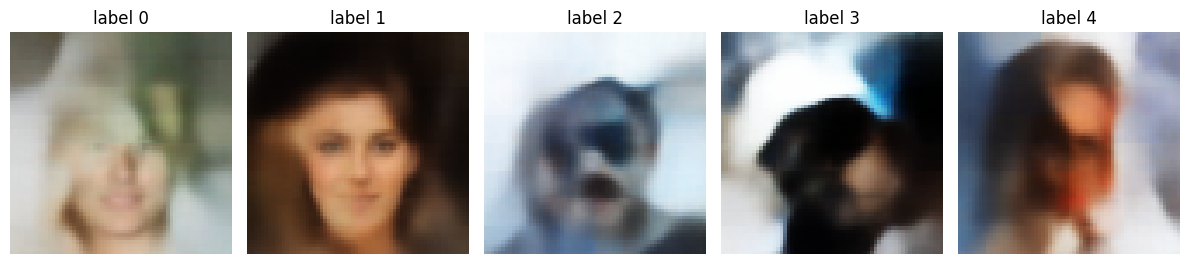

In [ ]:
labels_to_generate = torch.tensor([0, 1, 2, 3, 4], device=device)

with torch.no_grad():
    z = sample_latents(
        unet=unet,
        vae=vae,
        label_encoder=label_encoder,
        labels=labels_to_generate,
        num_steps=T,                
        guidance_scale=3.0
    )

    samples = vae.decode_from_2d_latent(z / 0.18215)


samples = samples.cpu()

samples = (samples + 1.0) / 2.0
samples = samples.clamp(0, 1)

plt.figure(figsize=(12, 3))
for i, lbl in enumerate(labels_to_generate):
    plt.subplot(1, len(labels_to_generate), i + 1)

    img = samples[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"label {lbl.item()}")

plt.tight_layout()
plt.show()


In [33]:
torch.save({
    "vae_state": vae.state_dict(),
    "diffusion_state": unet.state_dict(),
    "label_state": label_encoder.state_dict(),
}, "checkpoint_celeba_2.pth")
